<a href="https://colab.research.google.com/github/basarr/monte-carlo-engine/blob/main/05_mc_option_pricing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 5: Monte Carlo Pricing of a European Call Option

Goal:
- Price a European call option using Monte Carlo simulation
- Work under the GBM model
- Use risk-neutral valuation
- Compare Monte Carlo price with the Black–Scholes formula

This is the standard Monte Carlo pricing setup in quantitative finance.

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

np.random.seed(42)

## Model Assumptions

Under the risk-neutral measure, the asset price follows:

$
dS_t = r S_t \, dt + \sigma S_t \, dW_t
$

where:
- $r$ is the risk-free rate
- $\sigma$ is volatility

The payoff of a European call option is:

$
\max(S_T - K, 0)
$

The option price is the discounted expected payoff.

In [3]:
S0 = 100.0     # initial price
K = 100.0      # strike
r = 0.05       # risk-free rate
sigma = 0.2    # volatility
T = 1.0        # maturity (years)

n_paths = 200_000

## Monte Carlo Simulation of \( S_T \)

Under GBM, the terminal price satisfies:

$
S_T = S_0 \exp\left(
\left(r - \tfrac{1}{2}\sigma^2\right)T
+ \sigma \sqrt{T} Z
\right),
\quad Z \sim \mathcal{N}(0,1)
$

This allows us to simulate $S_T$ directly.

In [4]:
Z = np.random.randn(n_paths)

ST = S0 * np.exp(
    (r - 0.5 * sigma**2) * T
    + sigma * np.sqrt(T) * Z
)

## Payoff and Discounting

The Monte Carlo estimator of the option price is:

$
C_0 = e^{-rT} \mathbb{E}\left[\max(S_T - K, 0)\right]
$

In [5]:
payoff = np.maximum(ST - K, 0.0)

mc_price = np.exp(-r * T) * np.mean(payoff)
mc_price

np.float64(10.462392128395532)

## Black–Scholes Benchmark

The closed-form Black–Scholes price for a European call is:

$
C_0 = S_0 N(d_1) - K e^{-rT} N(d_2)
$

where:
$
d_1 = \frac{\log(S_0/K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma \sqrt{T}},
\quad
d_2 = d_1 - \sigma \sqrt{T}
$

In [6]:
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

bs_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
bs_price

np.float64(10.450583572185565)

## Comparison

We compare:
- Monte Carlo estimate
- Black–Scholes analytical price

Differences are due to Monte Carlo sampling error.

In [7]:
mc_price, bs_price, mc_price - bs_price

(np.float64(10.462392128395532),
 np.float64(10.450583572185565),
 np.float64(0.011808556209967236))

## Visualization: Payoff Distribution and Monte Carlo Convergence

We visualize:
- the distribution of discounted payoffs (what we are averaging)
- convergence of the Monte Carlo estimator toward the Black–Scholes benchmark
- a 95% confidence interval based on the Central Limit Theorem (CLT)

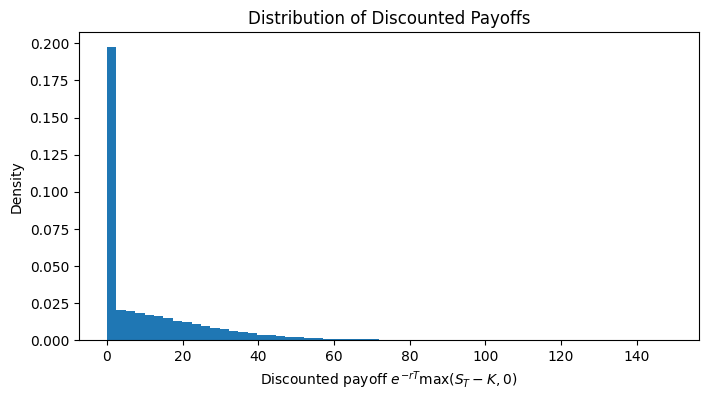

In [8]:
disc_payoff = np.exp(-r * T) * payoff

plt.figure(figsize=(8, 4))
plt.hist(disc_payoff, bins=60, density=True)
plt.xlabel("Discounted payoff $e^{-rT}\\max(S_T-K,0)$")
plt.ylabel("Density")
plt.title("Distribution of Discounted Payoffs")
plt.show()

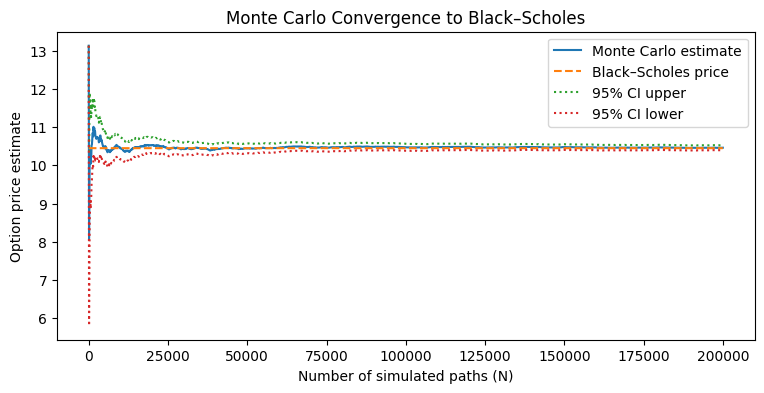

In [9]:
disc_payoff = np.exp(-r * T) * payoff

# cumulative mean estimator as we add more samples
cum_mean = np.cumsum(disc_payoff) / np.arange(1, n_paths + 1)

# cumulative (unbiased) sample variance via running second moment
cum_mean_sq = np.cumsum(disc_payoff**2) / np.arange(1, n_paths + 1)
cum_var = (cum_mean_sq - cum_mean**2)  # biased, but fine for large n
cum_se = np.sqrt(cum_var / np.arange(1, n_paths + 1))

ci_upper = cum_mean + 1.96 * cum_se
ci_lower = cum_mean - 1.96 * cum_se

# plot using a subset of points for speed/clarity
idx = np.linspace(1, n_paths, 2000, dtype=int) - 1

plt.figure(figsize=(9, 4))
plt.plot(idx + 1, cum_mean[idx], label="Monte Carlo estimate")
plt.plot(idx + 1, np.full_like(idx, bs_price, dtype=float), linestyle="--", label="Black–Scholes price")
plt.plot(idx + 1, ci_upper[idx], linestyle=":", label="95% CI upper")
plt.plot(idx + 1, ci_lower[idx], linestyle=":", label="95% CI lower")
plt.xlabel("Number of simulated paths (N)")
plt.ylabel("Option price estimate")
plt.title("Monte Carlo Convergence to Black–Scholes")
plt.legend()
plt.show()

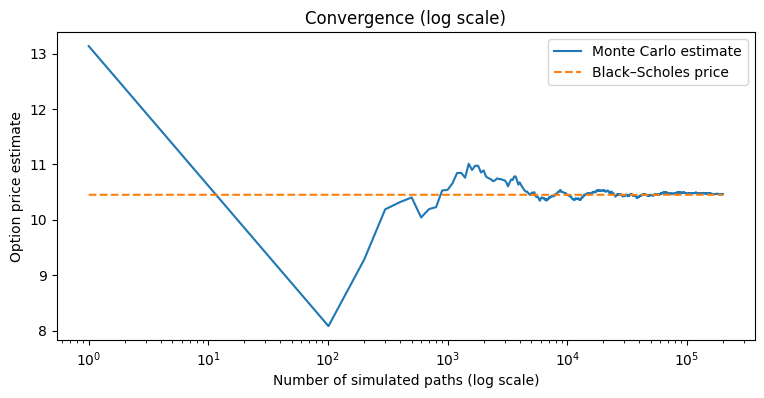

In [10]:
plt.figure(figsize=(9, 4))
plt.plot(idx + 1, cum_mean[idx], label="Monte Carlo estimate")
plt.plot(idx + 1, np.full_like(idx, bs_price, dtype=float), linestyle="--", label="Black–Scholes price")
plt.xscale("log")
plt.xlabel("Number of simulated paths (log scale)")
plt.ylabel("Option price estimate")
plt.title("Convergence (log scale)")
plt.legend()
plt.show()

Monte Carlo pricing converges slowly due to the skewed payoff distribution, but the estimator is unbiased and converges to the Black–Scholes price with uncertainty shrinking at the rate $1/\sqrt{N}$

## Summary

- Priced a European call option using Monte Carlo simulation
- Used risk-neutral GBM dynamics
- Discounted expected payoffs correctly
- Compared Monte Carlo results to the Black–Scholes formula

This completes the Monte Carlo pricing pipeline.